In [1]:
import numpy as np 
import matplotlib.pyplot as plt 
import matplotlib.colors as mcolors
import pandas as pd 
import random
import math
import time
import matplotlib.dates as mdates
from sklearn.linear_model import LinearRegression, BayesianRidge
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, mean_absolute_error
import datetime
from datetime import date
import operator 
from scipy.optimize import curve_fit
from scipy.optimize import fsolve
from scipy import integrate, optimize
#from covidmx import CovidMX
plt.style.use('fivethirtyeight')
%matplotlib inline 

In [2]:
DatosMexico=pd.read_csv('C:\\Users\\shada\\Documents\\Covid\\datosmexico.csv',index_col=0)
DatosMichoacan=pd.read_csv('C:\\Users\\shada\\Documents\\Covid\\datosmichoacan.csv',index_col=0)

In [3]:
##MOdelos
def exponential_model(x,a,b):
    return (a/b)*(np.exp(x*b)-1)

def gompertz_model(x,g):
    return k*np.exp(-n0*np.exp(-g*x))

def gompertz_hubbert(x,g):
    return g*n0*np.exp(-g*x)*k*np.exp(-n0*np.exp(-g*x))

def logistic_model(x,r,C0,K):
    return K/(1+((K-C0)/C0)*np.exp(-r*x))

def hubbert_curve(x,r,C0,K):
    return (np.exp(r*x)*r*C0*(K-C0))/(K*(1+C0/K *(np.exp(r*x) -1))**2)
def verhulst_model(y,x,r,K):
    dNdt=r*N*(1-N/K)
    return dNdt
def fit_log(x,r,K):
    return integrate.odeint(verhulst_model,N0,x,args=(r,K))[:,0]

In [4]:
def plot_50dias(df,country,final):
    df=df[:final]
    y2 = list(df.loc[:,'Nuevos'])
    y1 = list(df.loc[:,'Acumulados'])
    fecha=df.index[0]
    x= list(range(0,len(y2)))
    #condiciones iniciales
    
    time1 = pd.date_range(start=fecha, periods=len(y1))
    time2 = pd.date_range(start=fecha, periods=int(len(y1)+30))
    t1=np.linspace(1, int(len(y1)+30),int(len(y1)+30))
    t2=np.linspace(1, int(len(y1)),int(len(y1)))
    par,cov =curve_fit(logistic_model,x,y1,[1,y1[0],60000],maxfev=10000)
    tmax=np.log((par[2]-par[1])/par[1])/par[0]
    tmaxf=time1[int(tmax)]
    max1=logistic_model(tmax,par[0],par[1],par[2])
    max2=hubbert_curve(tmax,par[0],par[1],par[2])
   ###R_square1
    Infec1=logistic_model(t2,par[0],par[1],par[2])
    ss_tot1=np.sum((y1-np.mean(y1))**2)
    residual1=y1-Infec1
    ss_res1=np.sum(residual1**2)
    r_square1=1-(ss_res1/ss_tot1)
    r_square1=round(r_square1,3)
    
    ###R_square2
    Infec2=hubbert_curve(t2,par[0],par[1],par[2])
    ss_tot2=np.sum((y2-np.mean(y2))**2)
    residual2=y2-Infec2
    ss_res2=np.sum(residual2**2)
    r_square2=1-(ss_res2/ss_tot2)
    r_square2=round(r_square2,3)

    ###Grafica1 

    plt.figure(figsize=(20, 20))
    plt.subplot(2,1,1)
    #plt.plot(time1, fit_odeint1_1(t1,par_log1[0],par_log1[1],par_log1[2]),color='black',label='Modelo SIQR 1')
     #
    plt.text(time1[30],max(Infec1),'$R^2={}$'.format(r_square1),{'color': 'black', 'fontsize': 40})
    plt.scatter(tmaxf,max1,color="g",s=400,zorder=10)
    plt.text(time1[int(tmax-30)],max1,(tmaxf.strftime('%d-%m'),int(max1+1)),{'color': 'g', 'fontsize': 20})
    plt.bar(time1, y1,label='Casos Acumulados')
    plt.plot(time2, logistic_model(t1,par[0],par[1],par[2]),color='black',label='Modelo Logistico 1')
    plt.title('Casos acumulados en {}'.format(country), size=30)
    plt.xlabel('Dias desde {}'.format(time1[0].strftime('%d-%m-%Y')), size=30)
    plt.ylabel('# de Casos', size=30)
    locator = mdates.AutoDateLocator(minticks=5, maxticks=10)
    formatter = mdates.ConciseDateFormatter(locator)
    plt.gca().xaxis.set_major_locator(locator)
    plt.gca().xaxis.set_major_formatter(formatter)
    plt.gca().set_xlim(time1[0], time2[-1]+datetime.timedelta(days=8))
    #plt.gca().set_ylim(0, y_acum3[-1]+10000)
    plt.xticks(size=20)
    #plt.xticks(rotation=45)
    plt.yticks(size=20)   
    legend = plt.legend()
    
    plt.subplot(2,1,2)
    #plt.plot(time1, fit_odeint1_1(t1,par_log1[0],par_log1[1],par_log1[2]),color='black',label='Modelo SIQR 1')
     #
    plt.text(time1[30],max(Infec2),'$R^2={}$'.format(r_square2),{'color': 'black', 'fontsize': 40})
    plt.scatter(tmaxf,max2,color="g",s=400,zorder=10)
    plt.text(time1[int(tmax-30)],max2,(tmaxf.strftime('%d-%m'),int(max2+1)),{'color': 'g', 'fontsize': 20})
    plt.bar(time1, y2,label='Casos Nuevos Diarios')
    plt.plot(time2, hubbert_curve(t1,par[0],par[1],par[2]),color='black',label='Modelo Logistico 1')
    plt.title('Casos Nuevos en {}'.format(country), size=30)
    plt.xlabel('Días desde {}'.format(time1[0].strftime('%d-%m-%Y')), size=30)
    plt.ylabel('# de Casos', size=30)
    locator = mdates.AutoDateLocator(minticks=5, maxticks=10)
    formatter = mdates.ConciseDateFormatter(locator)
    plt.gca().xaxis.set_major_locator(locator)
    plt.gca().xaxis.set_major_formatter(formatter)
    plt.gca().set_xlim(time1[0], time2[-1]+datetime.timedelta(days=8))
    #plt.gca().set_ylim(0, y_acum3[-1]+10000)
    plt.xticks(size=20)
    #plt.xticks(rotation=45)
    plt.yticks(size=20)   
    legend = plt.legend()
    
    
    
    plt.savefig("E:\\Graficas\\Nuevos3meses{}-1.pdf".format(country), dpi=300, bbox_inches='tight')
    plt.show()
    print("Optimal parameters: r =", par[0], "  N0 = ", par[1], "K = ", par[2])
    return r_square1

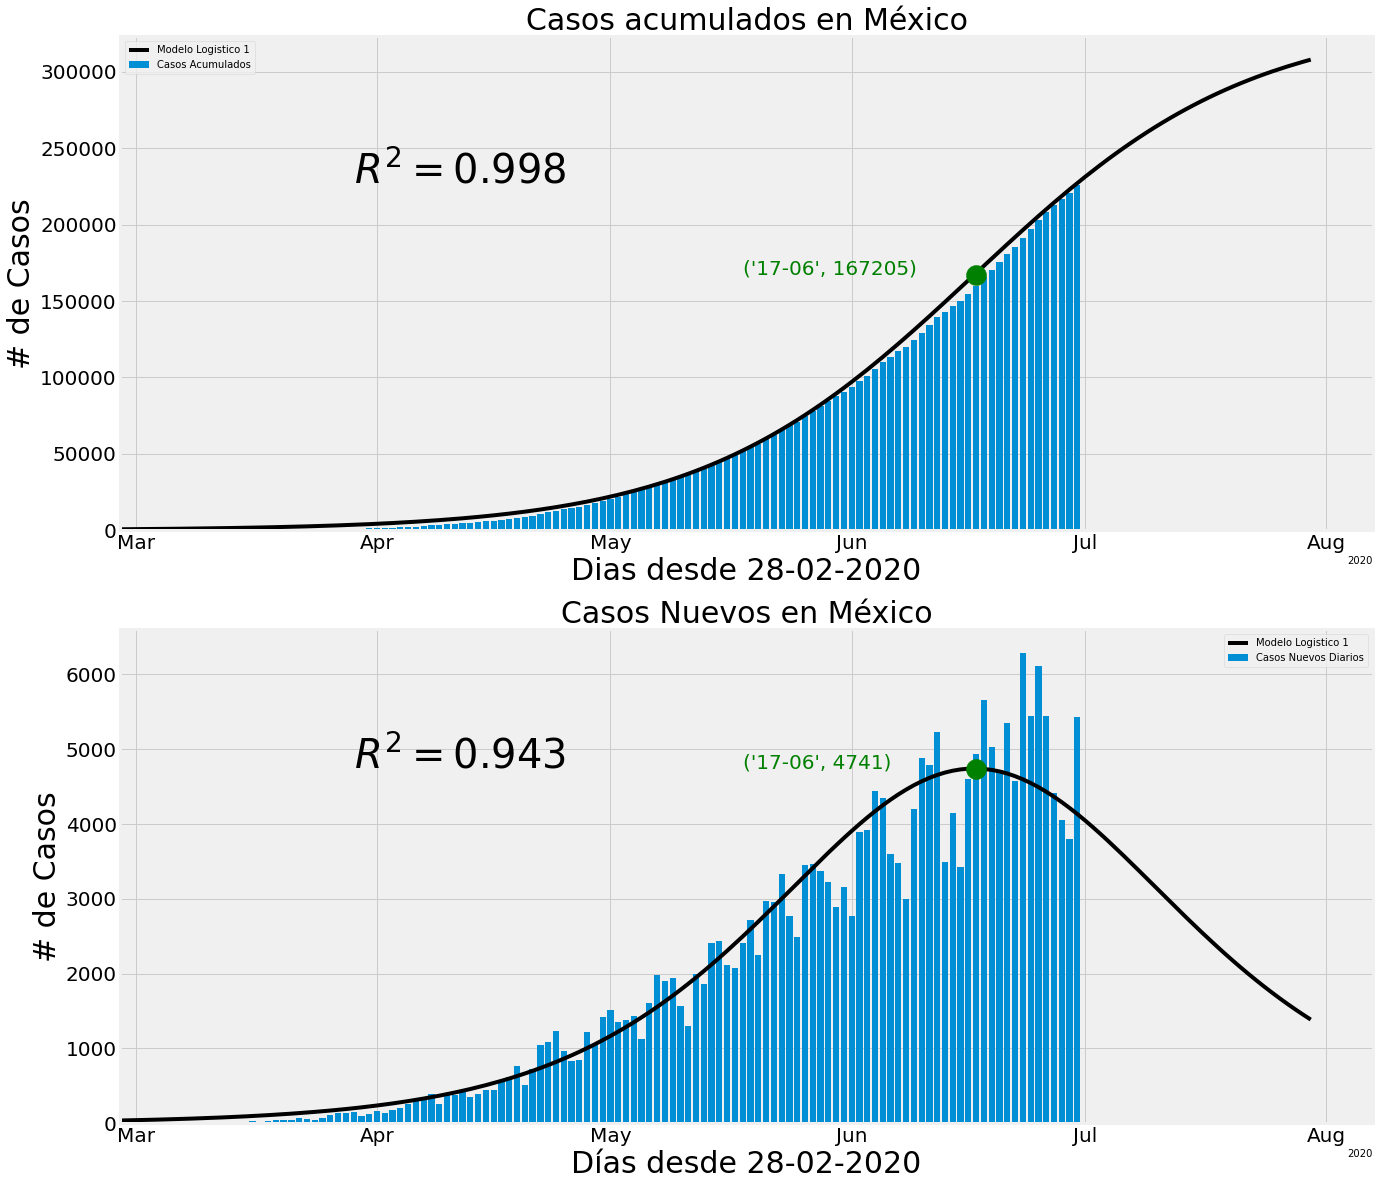

Optimal parameters: r = 0.05669881903442566   N0 =  624.7017746937528 K =  334408.21796362434


0.998

In [5]:
plot_50dias(DatosMexico,'México','2020-06-30')

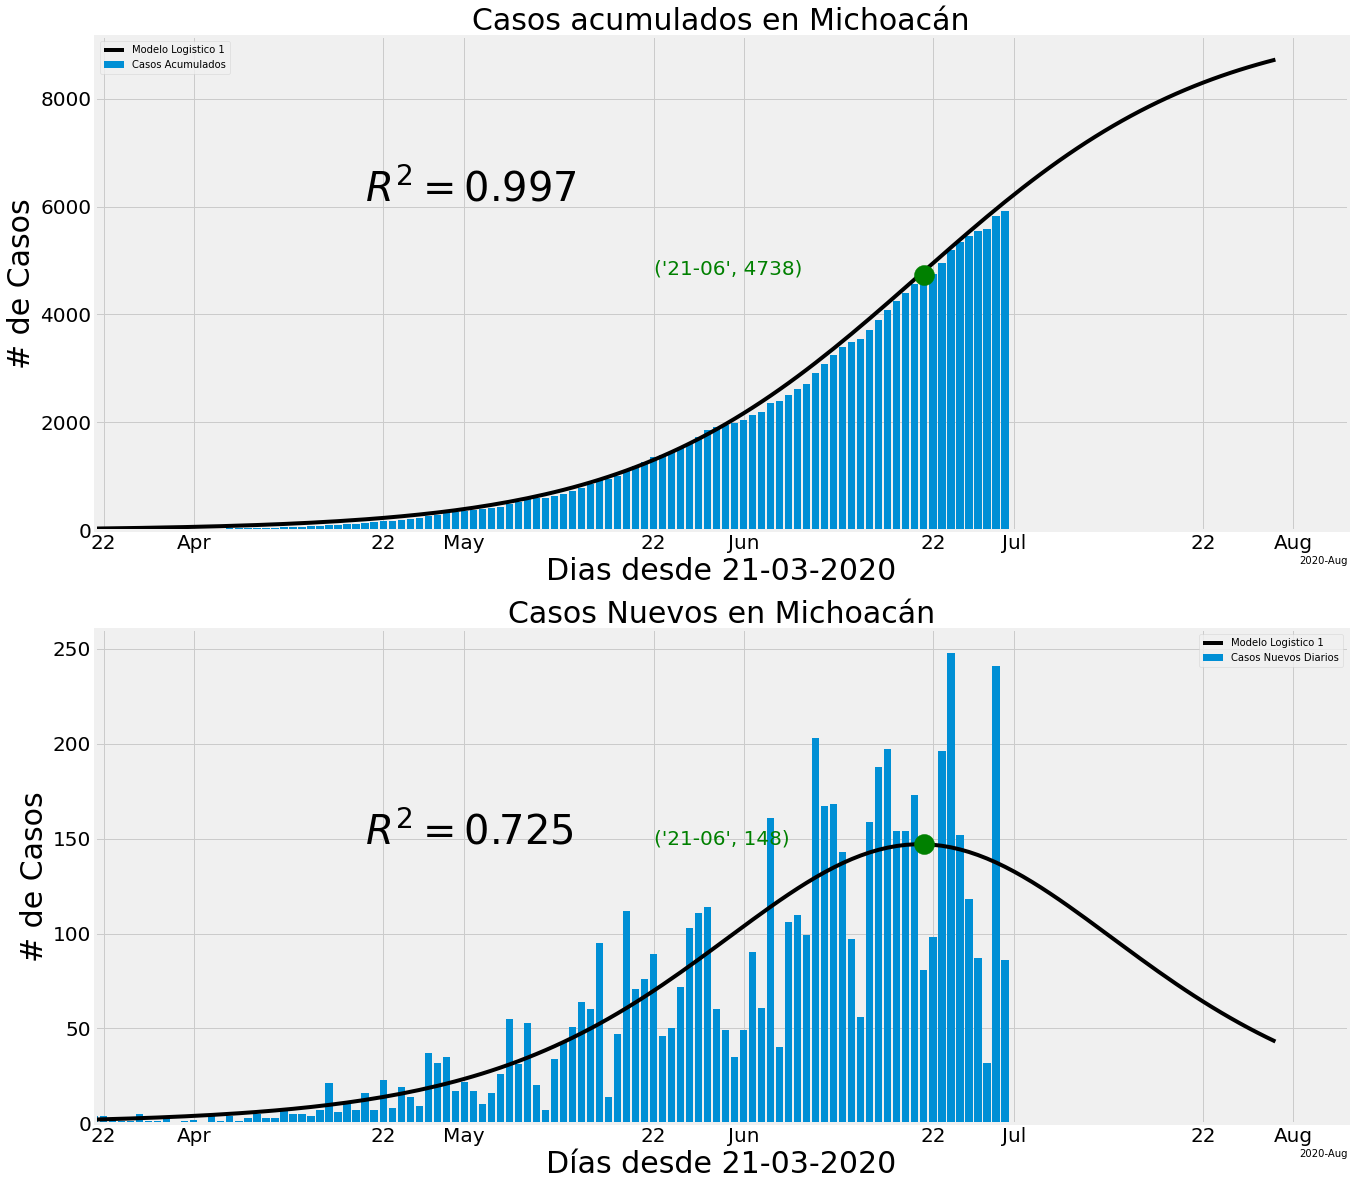

Optimal parameters: r = 0.06208063592050917   N0 =  30.16329428068263 K =  9475.91114285088


0.997

In [6]:
plot_50dias(DatosMichoacan,'Michoacán','2020-06-30')